In [115]:
import pandas as pd
import plotly as pl
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.cluster import AffinityPropagation, DBSCAN, Birch
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
import numpy as np
import math
from collections import Counter
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
DATA = pd.read_csv("online_shoppers_intention.csv")


Task 1: Get data on screen
Goal: Make visualizations that help understand the data

In [269]:
# New- vs. Returning customers pie chart

DATAvis = DATA
fig = px.pie(DATAvis, names='VisitorType', title='Types of Customers')
fig.update_layout(width=500)
fig.show()



# DURATION BOX PLOTTED
# Product related has a couple (<10) extreme outliers, had to filter those out
threshold = 10000 

filtered_data = DATA[
    (DATA['Administrative_Duration'] <= threshold) &
    (DATA['Informational_Duration'] <= threshold) &
    (DATA['ProductRelated_Duration'] <= threshold)
]

# Create a copy of the filtered data with better named columns
filtered_data_renamed = filtered_data.rename(columns={
    'Administrative_Duration': 'Administrative Duration',
    'Informational_Duration': 'Informational Duration',
    'ProductRelated_Duration': 'Product Related Duration'
})

fig = px.violin(filtered_data_renamed, y=['Administrative Duration', 'Informational Duration', 'Product Related Duration'])
fig.update_layout(
    title="Duration of Activities (Filtered)",
    yaxis_title="Duration (Seconds)",  
    xaxis_title='Variable',
    width=500  
)
fig.show()

# BOUNCERATES VS EXITRATES scatter
fig = px.scatter(DATAvis, x="BounceRates", y="ExitRates")
fig.update_layout(
    title="Bounce Rates vs Exit Rates",
    yaxis_title="Exit rates",  
    xaxis_title='Bounce Rates',
    width=500  
)
fig.show()


## PAGEVALUES PER MONTH
monthly_average = DATAvis.groupby('Month')['PageValues'].mean().reset_index()
# Create the line chart
fig = px.line(monthly_average, y="PageValues", x="Month", title="Average Page Values by Month")
fig.update_layout(
    yaxis_title="Page Values",  
    xaxis_title='Month',
    width=700  
)
fig.show()


# EXITRATES PER TRAFFICTYPE
fig = px.bar(DATAvis, x="TrafficType", y="ExitRates",
             color='TrafficType', barmode='stack',
             height=400)
fig.update_layout(
    yaxis_title="Exit Rates",  
    xaxis_title='Traffic Type',
    width=700  
)
fig.show()

purchase_counts = DATAvis[DATAvis['Revenue']].groupby('Month').size().reset_index(name='Count')

fig = px.bar(purchase_counts, x='Month', y='Count', title='Count of Purchases by Month')
fig.update_layout(
    width=700  
)
fig.show()

# PURCHASES CLOSE TO IMPORTANT DATES
SD_purchase_data = DATAvis[DATAvis['Revenue']]

SD_purchase_counts = SD_purchase_data['SpecialDay'].value_counts().reset_index()
SD_purchase_counts.columns = ['SpecialDay', 'Count']

SD_purchase_counts = SD_purchase_counts.sort_values('SpecialDay')

fig = px.line(SD_purchase_counts, x='SpecialDay', y='Count', title='Count of Purchases by Days to Special Day')
fig.update_layout(
    width=700  
)
fig.update_layout(xaxis=dict( autorange="reversed"))

fig.show()


browser_13_data = DATAvis[DATAvis['Browser'] == 13]
other_browser_data = DATAvis[DATAvis['Browser'] != 13]

DATAvis['BrowserType'] = DATAvis['Browser'].apply(lambda x: 'Browser 13' if x == 13 else 'Other Browsers')

fig = px.bar(DATAvis.groupby('BrowserType')['Revenue'].mean().reset_index(),
             x='BrowserType', y='Revenue', title='Proportion of Purchases: Browser 13 vs Other Browsers')
fig.update_layout(
    width=700,
    yaxis_title="Revenue",  
    xaxis_title='Type of Browser',
)

fig.show()



overall_summary = DATAvis.agg({
    'BounceRates': ['mean', 'median'],
    'ExitRates': ['mean', 'median'],
    'PageValues': ['mean', 'median'],
    'Administrative_Duration': ['mean', 'median'],
    'Informational_Duration': ['mean', 'median'],
    'ProductRelated_Duration': ['mean', 'median'],
    'SpecialDay': ['mean', 'median'],
}).reset_index()


browser_13_data = DATAvis[DATAvis['Browser'] == 13]
browser_13_summary = browser_13_data.agg({
    'BounceRates': ['mean', 'median'],
    'ExitRates': ['mean', 'median'],
    'PageValues': ['mean', 'median'],
    'Administrative_Duration': ['mean', 'median'],
    'Informational_Duration': ['mean', 'median'],
    'ProductRelated_Duration': ['mean', 'median'],
    'SpecialDay': ['mean', 'median'],
}).reset_index()

print("This is the overall summary:")
print(overall_summary)
print("This is the browser 13 summary")
print(browser_13_summary)


page_values_data = pd.DataFrame({
    'User Type': ['Overall'] + ['Browser 13'],
    'Page Values': [5.889258, 26.268249],
})

fig_page_values = px.bar(page_values_data, x='User Type', y='Page Values', 
                         title='Mean Page Values for Overall Users and Browser 13',
                         width = 700)

fig_page_values.show()

fig = px.box(DATAvis, y=['Administrative_Duration', 'Informational_Duration'], 
             color='BrowserType',
             title='Box Plots of Duration Metrics: Browser 13 vs Other Browsers')

fig.update_layout(
    yaxis_title="Duration (Seconds)",
    xaxis_title="Duration Type",
    yaxis_range=[0, 500],
    width=800
)
fig.show()

fig = px.box(DATAvis, y=['ProductRelated_Duration'], 
             color='BrowserType',
             title='Box Plot of Product Related Duration: Browser 13 vs Other Browsers')

fig.update_layout(
    yaxis_title="Duration (Seconds)",
    xaxis_title="Duration Type",
    width=800,
    yaxis_range=[0,5000]
)
fig.show()

This is the overall summary:
    index  BounceRates  ExitRates  PageValues  Administrative_Duration  \
0    mean     0.022191   0.043073    5.889258                80.818611   
1  median     0.003112   0.025156    0.000000                 7.500000   

   Informational_Duration  ProductRelated_Duration  SpecialDay  
0               34.472398              1194.746220    0.061427  
1                0.000000               598.936905    0.000000  
This is the browser 13 summary
    index  BounceRates  ExitRates  PageValues  Administrative_Duration  \
0    mean     0.034373   0.052842   26.268249                 73.71653   
1  median     0.000000   0.025000    0.000000                  0.00000   

   Informational_Duration  ProductRelated_Duration  SpecialDay  
0                4.717486               699.388395         0.0  
1                0.000000               302.000000         0.0  


There are no missing values in the dataset
Index(['Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
       'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
       'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3',
       'OperatingSystems_4', 'OperatingSystems_5', 'OperatingSystems_6',
       'OperatingSystems_7', 'OperatingSystems_8', 'Browser_1', 'Browser_2',
       'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7',
       'Browser_8', 'Browser_9', 'Browser_10', 'Browser_11', 'Browser_12',
       'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4',
       'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9',
       'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4',
       'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 'TrafficType_8',
       'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12',
       'TrafficType_13', 'TrafficType_14', 'TrafficType_15', 'TrafficType_16',

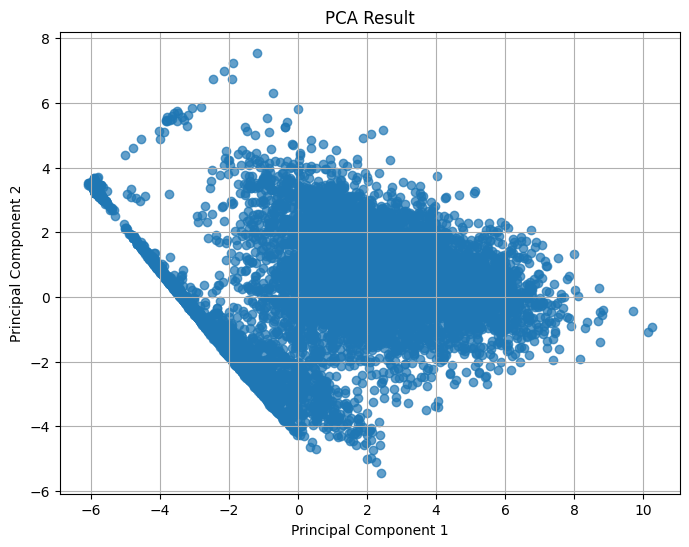

In [270]:

# cleaning

cleaneddata = DATA.dropna()
if len(DATA)-len(cleaneddata) == 0:
    print("There are no missing values in the dataset")

#candidates for one-hot-encoding (OHE)
featuresOHN = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']
cleaneddata[featuresOHN] = cleaneddata[featuresOHN].astype(str)
transformer = make_column_transformer((OneHotEncoder(categories='auto', sparse_output=False), featuresOHN), remainder='passthrough')
transformed = transformer.fit_transform(DATA)
df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

# clean column names for readability
flist = df.columns.to_list()
newflist = [col.replace('remainder__', '') if col.startswith('remainder__') else col.replace('onehotencoder__', '') for col in flist]
df.columns = newflist

# Assuming df is your DataFrame
print(df.columns)

boolcolumns = ['Weekend','Revenue']
for column in boolcolumns:
    cleaneddata[column] = cleaneddata[column].replace({'TRUE': 1, 'FALSE': 0})
    df[column] = df[column].replace({'TRUE': 1, 'FALSE': 0})
print(cleaneddata.columns)


encodedcolumns = ['OperatingSystems','Browser','Region','TrafficType','BrowserType']

dropencoded = False
for column in encodedcolumns:
    if dropencoded:
        df = df.drop(columns=[column])

#df = df.drop(columns=['Month','VisitorType'])
df = df.drop(columns=['BrowserType'])


# data normalization
featuresMinMax = ['BounceRates', 'ExitRates']
featuresZscore = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'PageValues']

for f in featuresMinMax:
    df[f] = (df[f] - df[f].min()) /(df[f].max() - df[f].min())

for f in featuresZscore:
    df[f] = df[f].astype(float)
    df[f] = np.log1p(df[f])

# Applying PCA
pca = PCA(n_components=2)  # Adjust the number of components as needed
pca_result = pca.fit_transform(df)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Print the explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("PCA Result Head:\n", pca_df.head())

# If you want to visualize the PCA results


plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
plt.title('PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()



#Take a random sample from the dataset which can be used for complexer models which do not scale well
df_sample = pca_df.sample(frac = 0.35)


Task 3: Clustering Algorithms
Goal: Succesfully use clustering algorithms

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



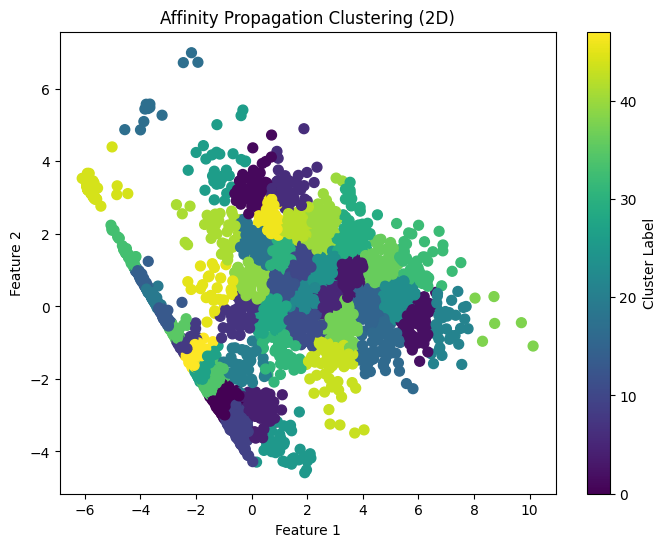

In [316]:
# Affinity Propagation, different blocks to test each clustering algorithm separately
affinity_propagation = AffinityPropagation(damping=0.9, max_iter=50, convergence_iter=50)
affinity_propagation.fit(df_sample)
affinity_labels = affinity_propagation.labels_

# Create a scatter plot of the clusters
plt.figure(figsize=(8, 6))

# Scatter plot colored by cluster label
plt.scatter(df_sample.iloc[:, 0], df_sample.iloc[:, 1], c=affinity_labels, cmap='viridis', s=50)

# Add plot title and labels
plt.title("Affinity Propagation Clustering (2D)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster Label")

# Show the plot
plt.show()




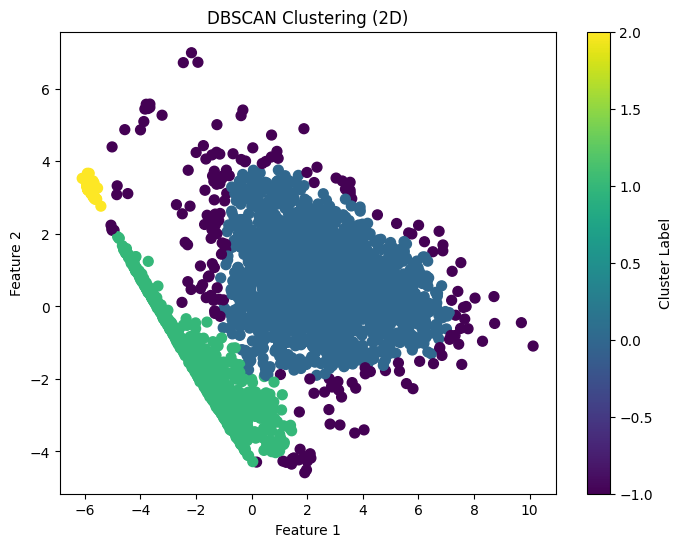

In [310]:
#DBSCAN, different blocks to test each clustering algorithm separately
dbscan = DBSCAN(eps=0.5, min_samples=20)
dbscan.fit(df_sample)
dbscan_labels = dbscan.labels_

# Create a scatter plot of the clusters
plt.figure(figsize=(8, 6))

# Scatter plot colored by cluster label
plt.scatter(df_sample.iloc[:, 0], df_sample.iloc[:, 1], c=dbscan_labels, cmap='viridis', s=50)

# Add plot title and labels
plt.title("DBSCAN Clustering (2D)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster Label")

# Show the plot
plt.show()

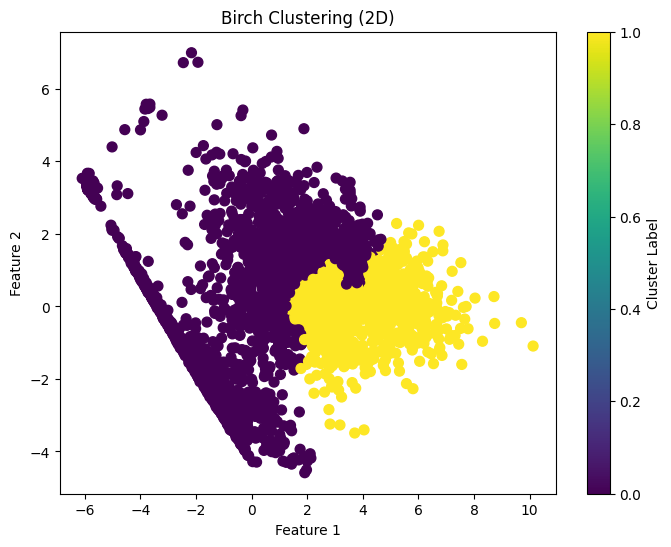

In [333]:
# BIRCH, different blocks to test each clustering algorithm separately
birch = Birch(threshold=0.5, n_clusters=2, branching_factor=200)
birch.fit(df_sample)
birch_labels = birch.labels_

# Create a scatter plot of the clusters
plt.figure(figsize=(8, 6))

# Scatter plot colored by cluster label
plt.scatter(df_sample.iloc[:, 0], df_sample.iloc[:, 1], c=birch_labels, cmap='viridis', s=50)

# Add plot title and labels
plt.title("Birch Clustering (2D)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster Label")

# Show the plot
plt.show()

Task 4: Evaluation of clustering methods
Goal: Be able to evaluate clustering methods using different evaluation measures and reason on their performance

In [162]:
# SILLHOUETTE SCORE

first_1000_rows = df_sample[:10]


def euclidean_distance(row1, row2):
    return np.sqrt(np.sum((row1 - row2) ** 2))


def silhouette_score(labels):

    unique_clusters = np.unique(labels)
    num_clusters = len(unique_clusters)

    for index, row in first_1000_rows.iterrows():
        print("ploink")
        current_cluster = birch_labels[index]
        Ci = list(labels).count(current_cluster)

        own_clust_dist = 0

        for index2, row2 in first_1000_rows.iterrows():
            if birch_labels[index2] == current_cluster and index2 != index:
                dist = euclidean_distance(row,row2)
                own_clust_dist += dist
        
        if Ci > 1:
            Ai = (1 / (Ci - 1)) * own_clust_dist
        else:
            Ai = 0

        min_distance = float('inf')  # Initialize minimum distance as infinity
        
        for j in range(num_clusters - 1):
            other_clust = unique_clusters[j]
            if other_clust != current_cluster:
                distance_sum = 0
                for index3,row3 in df_sample.iterrows():
                    if labels[index3] == other_clust:
                        distance_sum = euclidean_distance(row, row3)
                average_dist = distance_sum / list(labels).count(other_clust)
                if average_dist < min_distance:
                    min_distance = average_dist
                    neighboring_cluster = unique_clusters[j]
        Bi = min_distance
        
        if Ci > 1 and Bi != 0 and Ai != 0:
            Si = (Bi - Ai) / max(Bi,Ai)
        else:
            Si = 0
        
    return Si
         

#birch_sil_score = silhouette_score(birch_labels)
#print("The silhouette score for the birch clusterin algorithm is:", birch_sil_score)
#dbscan_sil_score = silhouette_score(dbscan_labels)
#print("The silhouette score for the dbscan clusterin algorithm is:", dbscan_sil_score)
affinity_sil_score = silhouette_score(affinity_labels)
#print("The silhouette score for the affinity propagation clusterin algorithm is:", affinity_sil_score)

ploink


IndexError: index 10423 is out of bounds for axis 0 with size 4316

In [123]:
# TASK 4.2 - Davies Bouldin Score
# minimum score is 0, with lower numbers indicating better clustering

birch_bouldin_score = davies_bouldin_score(df, birch_labels)
dbscan_bouldin_score = davies_bouldin_score(df, dbscan_labels)
affinity_bouldin_score = davies_bouldin_score(df, affinity_labels)

print("Davies Bouldin score for birch clustering:", birch_bouldin_score)
print("Davies Bouldin score for DBScan clustering:", dbscan_bouldin_score)
print("Davies Bouldin score for affinity propagation clustering:", affinity_bouldin_score)

dic = {birch_bouldin_score: "birch", dbscan_bouldin_score: "DBScan" , affinity_bouldin_score: "affinity propagation"}

print("The lowest score is the best result")
print("The best scoring algorithm is the", dic[min(birch_bouldin_score, dbscan_bouldin_score, affinity_bouldin_score)], "clustering algorithm")

ValueError: Found input variables with inconsistent numbers of samples: [12330, 4316]

In [164]:
# TASK 4.3 - Calinski Harabasz Score
# higher scores indicate better clustering

birch_harabasz_score = calinski_harabasz_score(df_sample, birch_labels)
dbscan_harabasz_score = calinski_harabasz_score(df_sample, dbscan_labels)
affinity_harabasz_score = calinski_harabasz_score(df_sample, affinity_labels)

print("Calinski Harabasz score for birch clustering:", birch_harabasz_score)
print("Calinski Harabasz score for DBScan clustering:", dbscan_harabasz_score)
print("Calinski Harabasz score for affinity propagation clustering:", affinity_harabasz_score)

dic1 = {birch_harabasz_score: "birch", dbscan_harabasz_score: "DBScan", affinity_harabasz_score: "affinity propagation"}

print("The highest score is the best result")
print("The best scoring algorithm is the", dic1[max(birch_harabasz_score, dbscan_harabasz_score, affinity_harabasz_score)], "clustering algorithm")

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [276]:
# 5.1: Manual Euclidian Distance
# 
def manual_euclidean_distance(p1, p2):

    distance = 0.0
    
    for i in range(len(p1)):
        distance += (p1[i] - p2[i]) ** 2
    
    return distance ** 0.5



# 5.2: Manual Manhatten Distance
def manual_manhattan_distance(p1, p2):
    distance = 0.0
    
    for i in range(len(p1)):
        distance += abs(p1[i] - p2[i]) # Absolute distance between 2 points
    
    return distance


#5.3: Manual Cosine Similarity Distance Function
def cosine_similarity(A, B):

    dot_product = sum(a * b for a, b in zip(A, B))
    
    norm_A = math.sqrt(sum(a ** 2 for a in A))
    norm_B = math.sqrt(sum(b ** 2 for b in B))
    
    # No division by 0
    if norm_A == 0 or norm_B == 0:
        return 0.0
    
    return dot_product / (norm_A * norm_B)

# Takes the cosine similarity and computes the distance
def manual_cosine_distance(A, B):
    return 1 - cosine_similarity(A, B)



In [277]:
# 5.4: Evaluating DBSCAN with different distance functions

# Taking subset for speed
#df_subset = df_sample.iloc[:500]
df_subset = df_sample




# Performing DBSCAN with manually implemented euclidian distance
eucl_dbscan = DBSCAN(eps=0.60, min_samples=40, metric=manual_euclidean_distance)
fit_euclid_dbscan = eucl_dbscan.fit(df_subset)
eucl_labs = fit_euclid_dbscan.labels_

print("eenn")

#DBSCAN Manhattan
man_dbscan = DBSCAN(eps=0.6, min_samples=24, metric=manual_manhattan_distance)
fit_manhattan_dbscan = man_dbscan.fit(df_subset)
man_labs = fit_manhattan_dbscan.labels_

print("tweeee")

#DBSCAN Cosine Similarity
cos_dbscan = DBSCAN(eps=0.0004, min_samples=30, metric=manual_cosine_distance)
fit_cos_dbscan = cos_dbscan.fit(df_subset)
cos_labs = fit_cos_dbscan.labels_
print("Unique labels for Cosine DBSCAN:", set(cos_labs))



# Calinski-Harabasz score
calinski_euclidean = calinski_harabasz_score(df_subset, eucl_labs)
calinski_manhattan = calinski_harabasz_score(df_subset, man_labs)

print("drieee")

# Davies-Bouldin Score
davies_euclidean = davies_bouldin_score(df_subset, eucl_labs)
davies_manhattan = davies_bouldin_score(df_subset, man_labs)

print("vieerrrr")





if len(set(cos_labs)) > 1:
    davies_cosine = davies_bouldin_score(df_subset, cos_labs)
    calinski_cosine = calinski_harabasz_score(df_subset, cos_labs)
    print(f"Calinski-Harabasz Index - Cosine: {calinski_cosine}")
else:
    print("Only one cluster found for Cosine Similarity; Calinski-Harabasz Index cannot be computed.")



# Display results
print(f"Calinski-Harabasz Index - Euclidean: {calinski_euclidean}")
print(f"Calinski-Harabasz Index - Manhattan: {calinski_manhattan}")
print(f"Davies-Bouldin Scores - Euclidean: {davies_euclidean}, Manhattan: {davies_manhattan}, Cosine: {davies_cosine}")


eenn
tweeee
Unique labels for Cosine DBSCAN: {0, 1, 2, 3, 4, 5, -1}
drieee
vieerrrr
Calinski-Harabasz Index - Cosine: 1882.1876183758775
Calinski-Harabasz Index - Euclidean: 3049.1570985386857
Calinski-Harabasz Index - Manhattan: 3020.7908653000727
Davies-Bouldin Scores - Euclidean: 2.7436838044464062, Manhattan: 3.0565281401439957, Cosine: 1.978794319562582


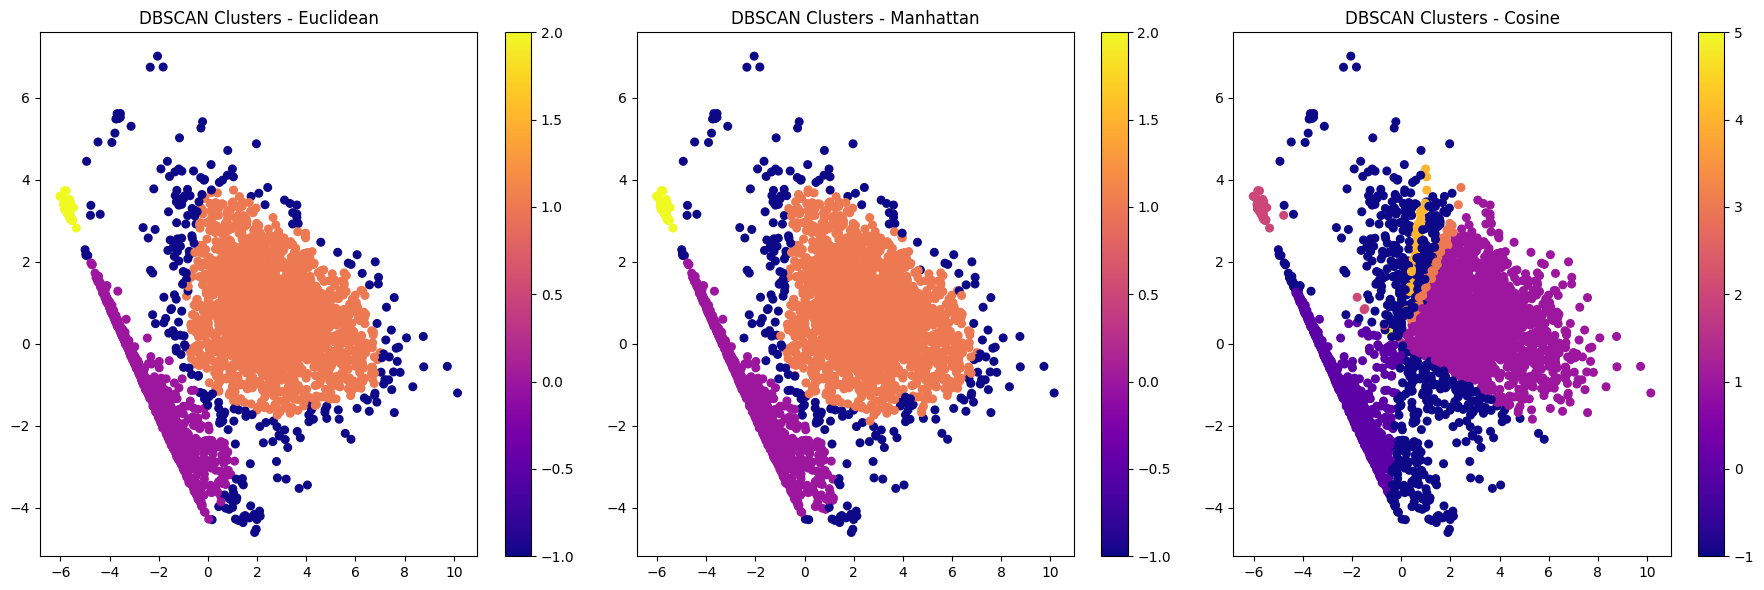

In [308]:


# Apply PCA to reduce data to 2 dimensions
pca = PCA(n_components=2)
dataOHN_subset_pca = pca.fit_transform(df_sample)  

# Create a 1x3 plot for visualizing clusters from the three DBSCAN methods
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Visualization for Euclidean DBSCAN
scatter1 = axes[0].scatter(dataOHN_subset_pca[:, 0], dataOHN_subset_pca[:, 1], c=eucl_labs, cmap='plasma', s=30)
axes[0].set_title('DBSCAN Clusters - Euclidean')
fig.colorbar(scatter1, ax=axes[0])

# Visualization for Manhattan DBSCAN
scatter2 = axes[1].scatter(dataOHN_subset_pca[:, 0], dataOHN_subset_pca[:, 1], c=man_labs, cmap='plasma', s=30)
axes[1].set_title('DBSCAN Clusters - Manhattan')
fig.colorbar(scatter2, ax=axes[1])

# Visualization for Cosine DBSCAN
scatter3 = axes[2].scatter(dataOHN_subset_pca[:, 0], dataOHN_subset_pca[:, 1], c=cos_labs, cmap='plasma', s=30)
axes[2].set_title('DBSCAN Clusters - Cosine')
fig.colorbar(scatter3, ax=axes[2])

# Show the plot
plt.tight_layout()
plt.show()



